In [1]:
import matplotlib.pyplot as plt
import numbers
import numpy as np
import pandas as pd
import paralytics as prl
import random
import re
import seaborn as sns
import warnings
import xgboost as xgb

from boruta import BorutaPy
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

sns.set_style('ticks')
%matplotlib inline

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Introduction

The goal I have chosen is to check what relationship characteristics are conducive to conversion to marriage. Therefore, I have limited myself only to the samples that do not explicitly state they are not in the relationship (variable $S2 == 2$) because therefore those people did not answer a lot of questions about their partners (quite obviously). 

In [2]:
df = pd.read_stata('hcmst_data.dta')

class ColumnNameLowcaser(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame), \
            'Input must be an instance of pandas.DataFrame()!'
        return X.rename(str.lower, axis='columns')

df = ColumnNameLowcaser().fit_transform(df[df.S2.cat.codes != 2])

We have removed samples which for sure were not in marriage so now we can select potentially informative columns and rename every column to its lowercase equivalent. One the first try we will stick to only the most obvious ones in terms of the [documentation](https://stacks.stanford.edu/file/druid:vt073cc9067/HCMST_2017_fresh_Codeboodk_v1.1a.pdf) transparency (very subjective on my part). That's why we will exclude every column containing one of: `refused` or `married` word or time variable because those will require special feature engineering. 

In [3]:
transparent_columns = [
    col for col in df.columns 
    if (
        re.search('^q\d', col)
        or col.startswith(('w6', 'time_', 'hcm2017q24'))
    )
    and not any([
        keyword in col 
        for keyword in ('refused', 'married', 'year', 'month')
    ])
]

transparent_columns.append('age_when_met')

A lot of times no information is an information but this time we will not go into details too much because it will require further investigation on missing values and by removing samples that had no partner at all I would expect to remove most of them. That's why columns with more than 10% of missings will be removed.

In [4]:
y = df.pop('s1').factorize()[0]
X = df

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=SEED 
)

X_train = X_train[transparent_columns].dropna(
    axis='columns',
    thresh=len(X_train) * .9
)

Lastly we can notice that a lot of categorical columns were read this way only due to containing the `Refused` category that is not numeric. We will find those variables and project them onto numeric types while imputing `Refused` category with adequate value.

In [5]:
class RefusedImputer(BaseEstimator, TransformerMixin):
    """Imputes 'Refused' category with np.nan. For columns that should be 
    of numerical type makes projection."""
    def fit(self, X, y=None):
        self.columns_to_convert_ = []
        self.columns_to_project_ = []
        for col in X.columns:
            try:
                col_categories = X[col].cat.categories.tolist()
            except AttributeError as e:
                continue
            if 'Refused' in col_categories:
                self.columns_to_convert_.append(col)
                col_categories.remove('Refused')
                rest_categories_numerical = all([
                    isinstance(cat, numbers.Number)
                    for cat in col_categories
                ])
                if rest_categories_numerical:
                    self.columns_to_project_.append(col)
                    
        return self
    
    def transform(self, X):
        X_new = X.copy()
        for col in self.columns_to_convert_:
            X_new[col] = X_new[col].replace({'Refused': np.nan})
            if col in self.columns_to_project_:
                X_new[col] = X_new[col].astype(float)
            else:
                X_new[col] = X_new[col].astype('category')
        
        return X_new

# Model pipeline

Before we will fit the model, we need to preprocess the data. We will do that in the following steps:

1. Turn every column name into its lowercase equivalent. That will let as select previously chosen columns in the next step.
2. Choose aforementioned columns.
3. Project `Refused` answer onto NaN value.
4. Project binary-like string aswers onto True/ False values.
5. Project column's dtypes onto float/ bool/ category adequately. That is done mainly for the purpose of the next step that selects categorical dtypes and sticks together sparse categories.
6. Group sparse categories.
7. Fit authorial [target/likelihood encoding](https://github.com/mrtovsky/Paralytics/blob/0.2.X/paralytics/encoding.py#L12) to the categorical features. Description can be found under the [link](https://github.com/mrtovsky/Paralytics/blob/0.2.X/paralytics/encoding.py#L13).
8. Impute missings for truely numerical features.
9. Select important features with use of the [Boruta Feature Selection](https://www.jstatsoft.org/article/view/v036i11/v36i11.pdf).
10. Reduce collinearity with use of [Variance Inflation Factor](https://github.com/mrtovsky/Paralytics/blob/0.2.X/paralytics/collinearity_reduction.py#L11).

The only problem is that BorutaPy requires to pass the data as the numpy.array and the [Paralytics package](https://github.com/mrtovsky/Paralytics/tree/0.2.X) on the other hand takes DataFrames as arguments most of the time. To solve this problem we will create a wrapper first. 

In [6]:
class BorutaPyWrapper(BorutaPy):
    def fit(self, X, y):
        try:
            super().fit(X, y)
        except TypeError as e:
            super().fit(X.values, y)
    
    def transform(self, X):
        try:
            X_new = super().transform(X)
        except TypeError as e:
            X_new = super().transform(X.values)
        selected_columns = np.array(X.columns)[self.support_]
        X_new = pd.DataFrame(X_new, columns=selected_columns)
        return X_new

    def fit_transform(self, X, y, weak=False):
        self.fit(X, y)
        return self.transform(X)

Now we can process to fitting our model.

In [7]:
selected_columns = X_train.columns.tolist()

KEYWORDS_TRUE = [
    'yes',
    'YES',
    'Yes',
    'Yes, we are a same-sex couple',
    'Yes, I am Married',
    'Yes, I have a sexual partner'
]

KEYWORDS_FALSE = [
    'no',
    'NO',
    'No',
    'No, we are an opposite-sex couple',
    'No, I am not Married'
]
rf = RandomForestClassifier(n_jobs=-1, max_depth=5, random_state=SEED)

xgb_model_pipeline = make_pipeline(
    ColumnNameLowcaser(),
    prl.preprocessing.ColumnSelector(columns=selected_columns),
    RefusedImputer(),
    prl.preprocessing.CategoricalBinarizer(
        keywords_true=KEYWORDS_TRUE, keywords_false=KEYWORDS_FALSE
    ),
    prl.preprocessing.ColumnProjector(),
    prl.preprocessing.CategoricalGrouper(new_cat='OtherCategory'),
    prl.TargetEncoder(cv=5, inner_cv=3, alpha=5, random_state=SEED),
    prl.preprocessing.Imputer(numerical_method='median'),
    BorutaPyWrapper(
        rf, n_estimators='auto', verbose=2,
        max_iter=150, random_state=SEED
    ),
    prl.VIFSelector(thresh=5., impute=False, verbose=1),
    xgb.XGBClassifier()
)

We will be filtering RuntimeWarning for stylistic purposes because the warning is raised by the `BorutaPy` object. This problem is not an issue (except stylistics obviously) and was fixed in this [pull request](https://github.com/scikit-learn-contrib/boruta_py/pull/35) but it's still not included in the package itself. 

In [8]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    xgb_model_pipeline.fit(X_train, y_train)

Iteration: 	1 / 150
Confirmed: 	0
Tentative: 	103
Rejected: 	0
Iteration: 	2 / 150
Confirmed: 	0
Tentative: 	103
Rejected: 	0
Iteration: 	3 / 150
Confirmed: 	0
Tentative: 	103
Rejected: 	0
Iteration: 	4 / 150
Confirmed: 	0
Tentative: 	103
Rejected: 	0
Iteration: 	5 / 150
Confirmed: 	0
Tentative: 	103
Rejected: 	0
Iteration: 	6 / 150
Confirmed: 	0
Tentative: 	103
Rejected: 	0
Iteration: 	7 / 150
Confirmed: 	0
Tentative: 	103
Rejected: 	0
Iteration: 	8 / 150
Confirmed: 	27
Tentative: 	10
Rejected: 	66
Iteration: 	9 / 150
Confirmed: 	27
Tentative: 	10
Rejected: 	66
Iteration: 	10 / 150
Confirmed: 	27
Tentative: 	10
Rejected: 	66
Iteration: 	11 / 150
Confirmed: 	27
Tentative: 	10
Rejected: 	66
Iteration: 	12 / 150
Confirmed: 	27
Tentative: 	6
Rejected: 	70
Iteration: 	13 / 150
Confirmed: 	27
Tentative: 	6
Rejected: 	70
Iteration: 	14 / 150
Confirmed: 	27
Tentative: 	6
Rejected: 	70
Iteration: 	15 / 150
Confirmed: 	27
Tentative: 	6
Rejected: 	70
Iteration: 	16 / 150
Confirmed: 	27
Tentative

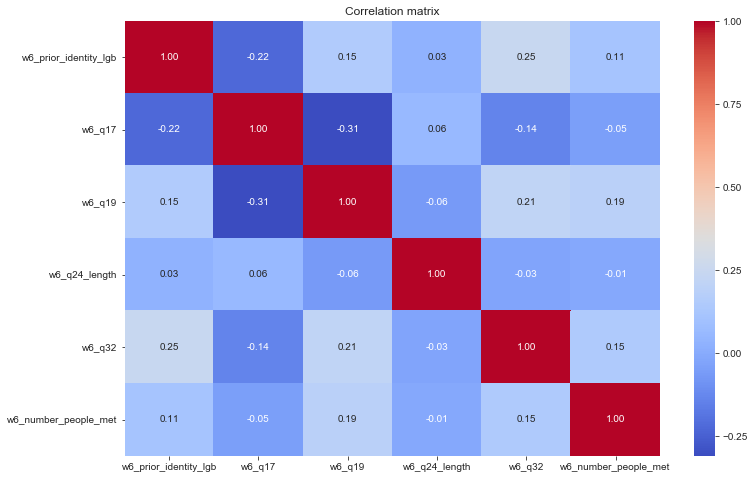

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))

X_train_transformed = Pipeline(
    xgb_model_pipeline.steps[:-1]
).transform(X_train)

ax = sns.heatmap(
    X_train_transformed.corr(), annot=True, fmt=".2f", 
    cmap="coolwarm", ax=ax
)
ax.set_title('Correlation matrix')
plt.show()

In [10]:
importances = (
    xgb_model_pipeline.named_steps['xgbclassifier']
    .feature_importances_
)

features = (
    xgb_model_pipeline.named_steps['vifselector'].kept_cols_
)

feat_importance_pairs = list(zip(features, importances))
feat_importance_pairs.sort(key=lambda x: x[1], reverse=True)

for feature, importance in feat_importance_pairs:
    print(
        'Variable "{0}" importance is equal to: {1:.2f}'
        .format(feature, importance)
    )

Variable "w6_q24_length" importance is equal to: 0.34
Variable "w6_q32" importance is equal to: 0.21
Variable "w6_q17" importance is equal to: 0.18
Variable "w6_q19" importance is equal to: 0.14
Variable "w6_prior_identity_lgb" importance is equal to: 0.11
Variable "w6_number_people_met" importance is equal to: 0.02


Accuracy is not the best metric to this problem because there is a bit unbalanced response variable but we will stick to the basics because performance of the model is not the main target.

In [11]:
from sklearn.metrics import accuracy_score


y_guessed = [0] * len(y_test)
y_pred = xgb_model_pipeline.predict(X_test)

print(
    'Model accuracy is equal to: {0:.2f}%. '
    'It can be benchmarked with a \nprediction that every '
    'sample is belonging to the majority class. \nIf so then the '
    'benchmark accuracy is: {1:.2f}%.'
    .format(
        accuracy_score(y_test, y_pred) * 100,
        accuracy_score(y_test, y_guessed) * 100
    )
)

Model accuracy is equal to: 92.32%. It can be benchmarked with a 
prediction that every sample is belonging to the majority class. 
If so then the benchmark accuracy is: 71.94%.


# Ceteris Paribus

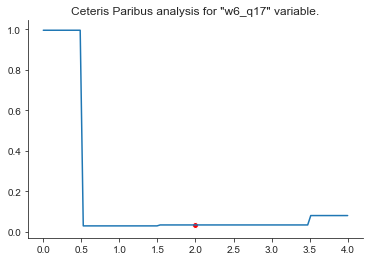

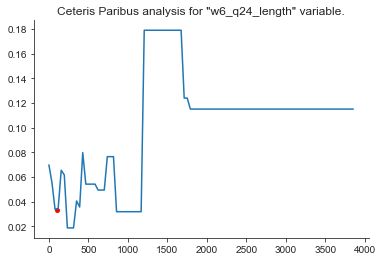

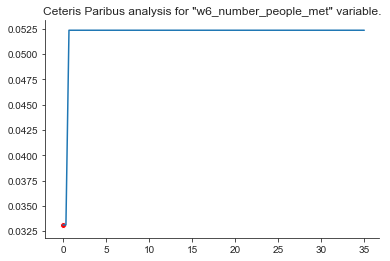

In [12]:
def plot_ceteris_paribus(model, record, variable_name, 
                         start, stop, n_obs):
    assert isinstance(record, pd.DataFrame), \
        'Chosen sample must be an instance of the pandas.DataFrame!'
    sample = record.copy()
    true_value = sample[variable_name].values[0]
    true_proba = model.predict_proba(sample)[0, 1]
    test_values = list(np.linspace(start, stop, n_obs))
    test_probas = []
    for val in test_values:
        sample[variable_name] = val
        try:
            test_probas.append(model.predict_proba(sample)[0, 1])
        except AttributeError as e:
            print('Model has to have implemented predict_proba method.b')
    fig, ax = plt.subplots()
    ax = sns.lineplot(test_values, test_probas, ax=ax)
    ax = ax.scatter(
        true_value, true_proba, marker='o', color='r', edgecolor='w'
    )
    plt.title(f'Ceteris Paribus analysis for "{variable_name}" variable.')
    sns.despine()
    plt.show()

for col in ['w6_q17', 'w6_q24_length', 'w6_number_people_met']:
    plot_ceteris_paribus(
        xgb_model_pipeline,
        X_test.iloc[777:778, :],
        col,
        X_test[col].min(),
        X_test[col].max(),
        100
    )